# Building ERD

Here is described how to build a ERD diagram using [dbml-renderer](https://github.com/softwaretechnik-berlin/dbml-renderer), [dbdiagram.io](https://dbdiagram.io/) and [dbdocs.io](https://dbdocs.io/).


## Building DBML

You can build DBML source code using `build_dbml` from `flypipe.misc.dbml`

In [1]:
from flypipe.misc.dbml import build_dbml

help(build_dbml)

Help on function build_dbml in module flypipe.misc.dbml:

build_dbml(nodes: Union[List[<property object at 0xf99150038680>.Node], <property object at 0xf99150038680>.Node], only_nodes_with_tags: Union[List[str], str] = None, only_nodes_with_cache: bool = False, file_path_name=None)
    Reads flypipe nodes and builds a dbml source code with the relationships, if output columns have been defined.
    
    Parameters
    ----------
    
    nodes : Union[List[Node], Node]
        nodes to be considered to be added to the dbml
    only_nodes_with_tags : Union[List[str], str], optional, defafult None
        include only nodes with tags
    only_nodes_with_cache: bool, optional, default True
        True: include nodes with cache, False: do not include nodes.
    
        Note: the cache objects must have name method implemented, example:
    
            class MyCache(Cache):
                ...
                @property
                def name(self):
                    return <NAME TO B

example:

In [2]:
from flypipe import node
from flypipe.cache import Cache
from flypipe.misc.dbml import build_dbml
from flypipe.schema import Schema, Column
from flypipe.schema.types import String
from pprint import pprint

class MyCache(Cache):
    def __init__(self, cache_name):
        self.cache_name = cache_name

    @property
    def color(self): # <-- ADDS THIS COLOR TO THE DBML TABLE
        return "#3498DB"

    @property
    def name(self): # <-- ADDS THIS NAME TO THE DBML TABLE
        return self.cache_name

    def read(self, spark):
        pass

    def write(self, spark, df):
        pass

    def exists(self, spark=None):
        pass
                
@node(
    type="pandas",
    description="this is node A",
    cache=MyCache("cache table a"),
    output=Schema(
        Column("node_a_col1", String(), "description node_a_col1"),
        Column("node_a_col2", String(), "description node_a_col2")
    )
)
def A():
    pass

@node(
    type="pandas",
    description="this is node B",
    output=Schema(
        Column("node_b_col1", String(), "description node_b_col1"),
        Column("node_b_col2", String(), "description node_b_col2"),
        Column("node_b_col3", String(), "description node_b_col3")
    )
)
def B(**dfs):
    pass

dbml = build_dbml(B)
print(f"{dbml}")

Table b {
	node_b_col1 String() [note: '''description node_b_col1''']
	node_b_col2 String() [note: '''description node_b_col2''']
	node_b_col3 String() [note: '''description node_b_col3''']

	Note: '''Managed by flypipe node `B`

this is node B'''
}


# Build the Relationships

You can define the relationships in the column definition:

``` python
@node(
    ...
    output=Schema(
        Column("node_b_col1", String(), "description node_b_col1", pk=True)
        .many_to_one(A.output.node_a_col1), # <-- relationship
        ...
    )
)
def B(**dfs):
    ...
```

<div class="admonition warning">
    <p class="admonition-title">Important</p>
    <p>
        You can easily cause python errors ``circular imports`` when importing nodes to define the relationships.
        In order to avoid circular dependency, it is recommented to keep a separated py file to define the relationships for your graph.
    </p>
</div>

## Here is how you can avoid circular dependecies:

In [3]:
# Example of relationships.py:
A.output.node_a_col1.pk = True
B.output.node_b_col1.pk = True
B.output.node_b_col2.pk = True

B.output.node_b_col1.many_to_one(A.output.node_a_col1)


    Column: node_b_col1
    Parent: B
    Data Type: String()
    Description: 'description node_b_col1
	Foreign Keys:
		B.node_b_col1 N:1 A.node_a_col1'
    PK: True
        

## Build ERD Diagram (SVG) using [dbml-renderer](https://github.com/softwaretechnik-berlin/dbml-renderer)

In [4]:
from flypipe.misc.erd import build_erd_svg
help(build_erd_svg)

build_erd_svg(B, "test.svg")

Help on function build_erd_svg in module flypipe.misc.erd:

build_erd_svg(nodes: Union[List[<property object at 0xf99150038680>.Node], <property object at 0xf99150038680>.Node], output_path, only_nodes_with_tags: Union[List[str], str] = None, only_nodes_with_cache: bool = False)
    Reads flypipe nodes and builds a SVG image with the ERD diagram
    
    Parameters
    ----------
    
    nodes : Union[List[Node], Node]
        nodes to be considered to be added to the dbml
    output_path: str
        full file path name where the svg is stored.
    only_nodes_with_tags : Union[List[str], str], optional, defafult None
        include only nodes with tags
    only_nodes_with_cache: bool, optional, default True
        True: include nodes with cache, False: do not include nodes.
    
        Note: the cache objects must have name method implemented, example:
    
            class MyCache(Cache):
                ...
                @property
                def name(self):
             

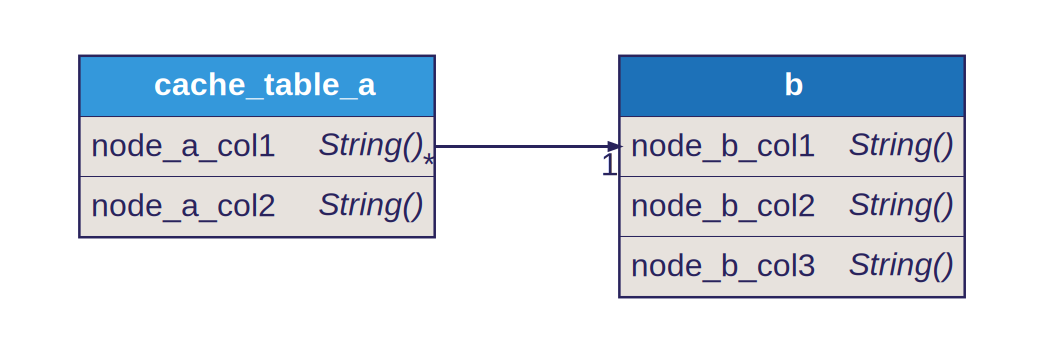

In [5]:
from IPython.display import SVG, display

display(SVG(filename="test.svg"))  # Replace with your SVG file path


## [dbdiagram.io](https://dbdiagram.io/)

Import the DBML file into dbdiagram

```sql
Table b {
	node_b_col1 String() [note: '''description node_b_col1''', PK]
	node_b_col2 String() [note: '''description node_b_col2''', PK]
	node_b_col3 String() [note: '''description node_b_col3''']

	Note: '''Managed by flypipe node `B`

this is node B'''
}

Ref : cache_table_a.node_a_col1 > b.node_b_col1

Table cache_table_a [headercolor: #3498DB] {
	node_a_col1 String() [note: '''description node_a_col1''', PK]
	node_a_col2 String() [note: '''description node_a_col2''']

	Note: '''Managed by flypipe node `A`

this is node A'''
}
```

following is an example of the dbdiagram

In [6]:
from IPython.display import IFrame

IFrame("https://dbdiagram.io/e/67c9e4b0263d6cf9a07dd726/67c9e4f6263d6cf9a07dde8e", width=800, height=600)

## [dbdocs.io](https://dbdocs.io/)

1. Follow dbdocs the [installation steps](https://docs.dbdocs.io/#1-install-dbdocs-via-terminal)
2. [Login](https://docs.dbdocs.io/#3-login-to-dbdocs)
3. [Publish your DBML file](https://docs.dbdocs.io/#3-login-to-dbdocs)

You can acess [this example](https://dbdocs.io/joseheliomuller/flypipe).

In [7]:
from IPython.display import IFrame

IFrame("https://dbdocs.io/joseheliomuller/flypipe", width=1280, height=1000)